# Prévision de la hausse ou de la baisse du prix de l'électricité : régression logistique  polynomiale 
Le jeu de données étudié comporte  4 années de consommation électrique, de prix et de production pour l'Espagne. Les données de consommation et de production ont été extraites de l'ENTSOE, un 
portail public pour les données des opérateurs de services de transmission. Les prix de l'électricité ont été obtenus auprès du GRT espagnol Red Electric España.
[Source](https://transparency.entsoe.eu/dashboard/show)

Prédire les écarts importants entre le prix actuel et  le prix day ahead.  
Pour cela, vous allez 
- implémenter la régression logistique polynomiale et tester différents ordres pour le polynôme.
- vérifier les performances des modèles en utilisant les métriques appropriées à la classification.
- détecter l'overfitting  
- tester au moins un type de régularisation (L1, L2, Elastic-Net) pour contrer l'overfitting et vérifier l'amélioration des performances avec régularisation.

Ce notebook vous aide à commencer en définissant les features et outputs /classes.

Les contraintes sont l'utilisation du module scikit learn, même si vous verrez d'autres outils plus tard. 

Pour vous aider dans l'implémentation, vous trouverez les modules nécessaires sur cette page web :  
https://scikit-learn.org/stable/api/sklearn.linear_model.html

# <a id='ref1'> Importation des modules </a>  

A compléter avec les modèles et méthodes adaptées à la classification avec régression logistique


In [1]:
#importation des librairies de manipulation de données et de visualisation
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

%matplotlib inline
sns.set_theme(style = "darkgrid", palette = "husl")
sns.set_context("talk")

# importation des librairies de machine learning

# prétraitement
from sklearn.preprocessing import StandardScaler

# modèles 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# calcul de performance
from sklearn.model_selection import LearningCurveDisplay


In [8]:
# importation des librairies de machine learning pour la classification
# à compléter

import numpy as np

# <a id='ref1'>1. Charger les données  d'apprentissage et de test</a>


In [3]:
# Read the energy data from the CSV file
df_energy = pd.read_csv('data/ISC_Spain_Energy.csv')

# Define the features and target variable
features = ["generation biomass (MW)", "generation fossil brown coal/lignite (MW)", "generation fossil gas (MW)",
            "generation fossil hard coal (MW)", "generation fossil oil (MW)", "total load actual (MW)",
            "price day ahead (EUR/MWh)", "price for the previous hour (EUR/MWh)","total production (MW)"]
X_train = df_energy[features]
y_train = (df_energy["price actual (EUR/MWh)"] - df_energy["price day ahead (EUR/MWh)"]).abs()>8

# test data
newdf_energy = pd.read_csv('data/ISC_Spain_Energy_NewData.csv')
X_test = newdf_energy[features]

y_test = pd.read_csv('data/ISC_Spain_Energy_NewDataSolution.csv')
y_test = (y_test["price actual (EUR/MWh)"] - newdf_energy["price day ahead (EUR/MWh)"]).abs()>8


Vous pouvez ( et devez) vérifier ce que contient la variable `y_train` et `y_test`. En particulier si le ratio de 0 et de 1 sont à peu près les mêmes pour les deux jeux de données

In [4]:
y_train.value_counts()/len(y_train)

False    0.507344
True     0.492656
Name: count, dtype: float64

In [5]:
y_test.value_counts()/len(y_test)

False    0.506488
True     0.493512
Name: count, dtype: float64

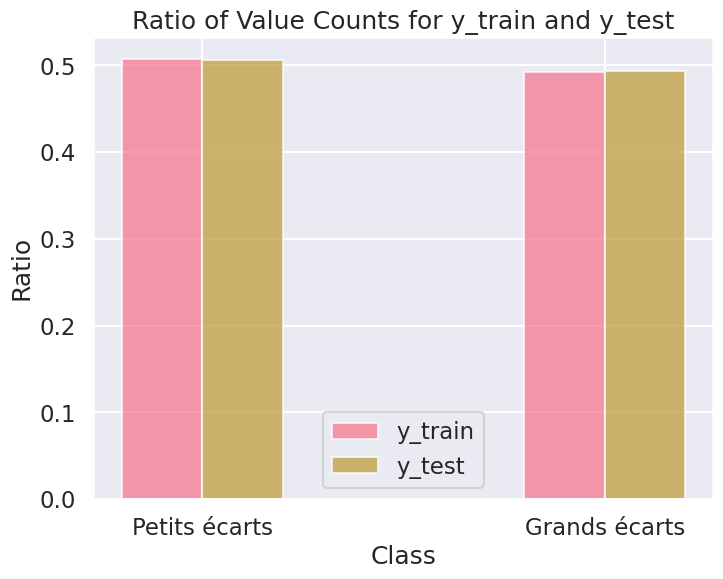

In [6]:

# Calculate value counts and ratios for y_train
train_counts = y_train.value_counts()
train_ratios = train_counts / len(y_train)

# Calculate value counts and ratios for y_test
test_counts = y_test.value_counts()
test_ratios = test_counts / len(y_test)

# Create a barplot
plt.figure(figsize=(8, 6))
plt.bar(train_ratios.index, train_ratios, label='y_train', alpha=0.7,width=0.2)  # Plot the bars for y_train
plt.bar(test_ratios.index + 0.2, test_ratios, label='y_test', alpha=0.7,width=0.2)  # Shift the bars for y_test
plt.xlabel('Class')
plt.xticks(train_ratios.index+0.1, ["Petits écarts", "Grands écarts"])
plt.ylabel('Ratio')
plt.title('Ratio of Value Counts for y_train and y_test')
plt.legend()
plt.show()

Il est aussi utile d'afficher la valeur de, par exemple, le prix day ahead et les prix réels  

/tmp/ipykernel_8979/2175357159.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i[1][-1] > i[1][-3]:   # -1 => price actual, -3 => price previous hour


[True, False, True, True, True, True, True, False, True, False, True, False, False, False, False, True, False, True, False, True, False, True, False, False, False, True, False, True, False, True, True, True, True, False, True, True, False, False, False, False, True, False, True, True, False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, True, True, False, False, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, True, True, False, False, True, False, True, True, True, False, False, False, False, False, True, True, True, False, False, False, False, True, False, False, True, True, True, True, True, True, False, True, True, True, True, False, True, False, False, False, True, True, False, True, True, True, False, False, False, False, True, False, True, False, True, True, False, True, False, False, False, True, False, T

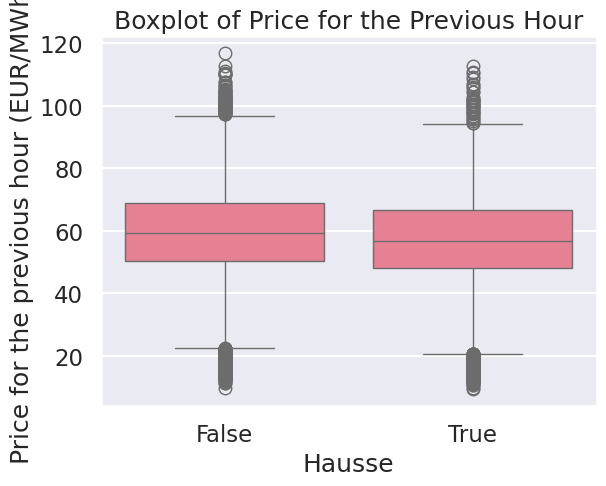

In [19]:
import seaborn as sns

# ????? pas trop sur de ce qui se passe ici...

riseList: list[bool] = []
for i in df_energy.iterrows():
    if i[1][-1] > i[1][-3]:   # -1 => price actual, -3 => price previous hour
        riseList.append(True)
    else: 
        riseList.append(False)

print(riseList)

df_energy['Hausse'] = riseList

# Create a boxplot
sns.boxplot(data=df_energy, x='Hausse', y='price for the previous hour (EUR/MWh)')

# Set the labels and title
plt.xlabel('Hausse')
plt.ylabel('Price for the previous hour (EUR/MWh)')
plt.title('Boxplot of Price for the Previous Hour')

# Show the plot
plt.show()

Connaître le prix de l'heure précédente n'aide pas beaucoup pour prédire si il y a baisse ou hausse.  
Essayons tout de même en utilisant les mêmes features que pour les notebooks sur la régression.

# <a id='ref2'>2. Implémentation d'un modèle de régression logistique polynomiale et choix de l'ordre du polynome</a>


Dans cette partie, vous devez créer un modèle linéaire sans régularisation qui va prédire lorsque le prix réel (inconnu) s'écarte trop du prix day ahead à partir de `features`.   
La procédure d'apprentissage consiste à estimer les paramètres de ce modèle de régression logistique linéaire.  
- **Trouver la méthode sous scikitlearn et implémentez là.**
- **Estimer les paramètres du modèle et calculer l'erreur sur les données en utilisant la métrique `accuracy_score` vue en cours.**   Elle va de 0 à 1  


- **Ajouter ensuite des calculs de termes polynomiaux et augmenter l'ordre des polynômes jusqu'à détecter l'overfitting**

# <a id='ref3'>3. Réduire l'overfitting avec régularisation </a>
Nous voudrions savoir si le modèle qui fait de l'overfitting pourrait avec de l'aide améliorer ses performances sur les données test.  
C'est le moment de tester les deux méthodes de régularisation vues en cours :
- la L2 (norme 2), aussi appelée Ridge Regression  ou régularisation de Tikhonov : 
- la L1 (norme L1) aussi appelée Lasso Regression : sous scikit learn  Logistic Regression 


La régularisation modifie la fonction coût /objectif à minimiser en ajoutant un terme supplémentaire. Il faut donc choisir le poids, l'importance de ce terme.   
Trouver la méthode sous scikit learn qui permet de choisir le type de régularisation et le paramètre qui permet de régler l'importance de ce terme.


# <a id='ref4'>4. Wrap-up et conclusion </a>
Faites un graphique permettant de montrer pourquoi le modèle et la fonction coût choisi sont les meilleurs.  
Argumentez